In [2]:
import sys
import os
import cv2
import random
import itertools
import shutil
import glob
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sklearn as sk
import tensorflow as tf
import seaborn as sn
import regex as re
from skimage  import io
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import img_as_ubyte, img_as_float
from scipy import ndimage as nd
from PIL import Image
import plotly
import tensorflow.keras
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model ,Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization,Input,add,Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import concatenate 
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint,LearningRateScheduler
from sklearn.metrics import plot_confusion_matrix, roc_curve, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score
%matplotlib inline

# Extracting the training images as CSV

In [7]:
dataset_folder='TrainImages 13376'
os.chdir(dataset_folder)
X = []
for i in os.listdir():
    img = cv2.imread(i,cv2.THRESH_BINARY)
    if img is None:
        continue
    else:
        newX = cv2.resize(img,(32,32))
        X.append(newX)
os.chdir('../../')
X = np.array(X).reshape(-1,1024)

df=pd.DataFrame(X)

df.to_csv('KaggleTrainingImagesCleaned.csv',index=False, header=False)

# Extracting the training labels as CSV

In [8]:
dataset_folder='TrainImages 13376'
file_name=[]
for entry in os.scandir(dataset_folder):
    if entry.path.endswith(".png") and entry.is_file():
        file_name.append(entry.name)
labels = []
for label in file_name:
    a=re.search(r"l_[\d]+",label)
    b=a.group()
    regex=re.sub(r"l_","",b)
    l={
        'label' : regex
    }
    labels.append(l)
df1 = pd.DataFrame(labels)
df1.to_csv('KaggleTrainingLabelsCleaned.csv',index=False , header=False)

# Extracting the testing images as CSV

In [9]:
dataset_folder='TestImages 3354'
os.chdir(dataset_folder)
X = []
for i in os.listdir():
    img = cv2.imread(i,cv2.THRESH_BINARY)
    if img is None:
        continue
    else:
        newX = cv2.resize(img,(32,32))
        X.append(newX)
os.chdir('../../')
X = np.array(X).reshape(-1,1024)

df=pd.DataFrame(X)

df.to_csv('KaggleTestingImagesCleaned.csv',index=False, header=False)

# Extracting the testing labels as CSV

In [10]:
dataset_folder='TestImages 3354'
file_name=[]
for entry in os.scandir(dataset_folder):
    if entry.path.endswith(".png") and entry.is_file():
        file_name.append(entry.name)
labels = []
for label in file_name:
    a=re.search(r"l_[\d]+",label)
    b=a.group()
    regex=re.sub(r"l_","",b)
    l={
        'label' : regex
    }
    labels.append(l)
df1 = pd.DataFrame(labels)
df1.to_csv('KaggleTestingLabelsCleaned.csv',index=False , header=False)

# Pre-processing the images

In [11]:
# reading the csv files as Pandas dataframes
x_train = pd.read_csv("KaggleTrainingImagesCleaned.csv",header=None )
y_train = pd.read_csv("KaggletrainingLabelsCleaned.csv",header=None)
x_test=pd.read_csv("KaggleTestingImagesCleaned.csv" ,header=None)
y_test=pd.read_csv("KaggleTestingLabelsCleaned.csv" ,header=None)

# converting from dataframes to numpy array
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)


# divide the images values by 255 (Normalizing) to improve the performance
x_train = x_train/255
x_test = x_test/255


# Splitting training data into training\validation
seed = 10
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=seed,stratify=y_train)

# reshaping the images values from the number of images x 1024 to number of images x size of images x color channel
x_train = x_train.reshape([-1, 32, 32, 1])
x_test = x_test.reshape([-1, 32, 32, 1])
x_val= x_val.reshape([-1, 32, 32, 1])

# reshaping the labels into one row
y_train=y_train.reshape(-1)
y_test=y_test.reshape(-1)
y_val=y_val.reshape(-1)
y=y_train

# one hot encoding
y_train=pd.get_dummies(y_train).values
y_test=pd.get_dummies(y_test).values 
y_val=pd.get_dummies(y_val).values 

# Plotting the training dataset count

C:\Users\MOneb\anaconda3\envs\ev_2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



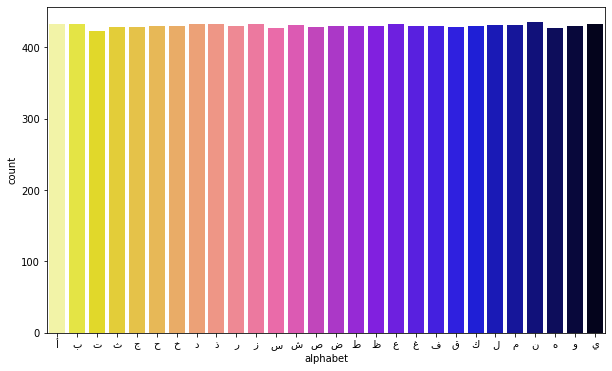

In [12]:
y=pd.DataFrame(y)
y.rename(columns={0:"abc"},inplace=True)
cha_dic={1:"أ", 2:"ب",3:"ت",4:"ث",5:"ج",6:"ح",7:"خ",8:"د",9:"ذ",10:"ر",11:"ز",12:"س",13:"ش",14:"ص",15:"ض",16:"ط",17:"ظ",18:"ع"
,19:"غ",20:"ف",21:"ق",22:"ك",23:"ل",24:"م",25:"ن",26:"ه",27:"و",28:"ي"}

organized=["أ" ,"ب" ,"ت" ,"ث" ,"ج" ,"ح" ,"خ" ,"د" ,"ذ" ,"ر" ,"ز","س","ش","ص","ض","ط","ظ","ع","غ","ف","ق","ك","ل","م","ن","ه","و","ي"]

temp=y.abc.apply(lambda x:cha_dic[x])
plt.figure(figsize=(10,6))
co=sn.countplot(temp,palette="gnuplot2_r",order=organized)
plt.xlabel("alphabet")
plt.show()

# Show examples of the dataset

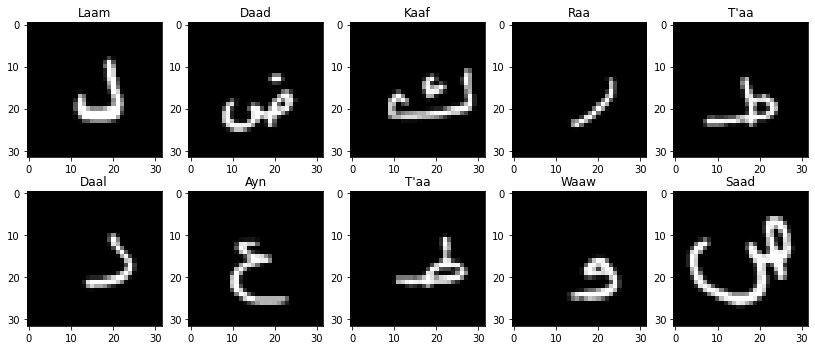

In [13]:
arabic_characters = ['Alef', 'Baa', 'Taa', 'Thaa', 'Jeem', "H'aa", 'Khaa', 'Daal', 'Thaal',
                    'Raa', 'Zaay', 'Seen', 'Sheen', 'Saad', 'Daad', "T'aa", 'Dhaa', 'Ayn',
                    'Ghayn', 'Faa', 'Qaaf', 'Kaaf', 'Laam', 'Meem', 'Noon', 'Haa', 'Waaw', 'Yaa']
y_class = [np.argmax(element) for element in y_train]

plt.figure(figsize=(14,15))
for i in range(10):
    plt.subplot(5,5,i+1)
    x = random.randint(0, 6000)
    plt.imshow(x_train[x].reshape(32,32),"gray")
    plt.title(arabic_characters[y_class[x]])
plt.show()

# ANN model

In [25]:
model = Sequential()
model.add(Flatten(input_shape=(32, 32,1)))
model.add(Dense(3000, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1500, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(750, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(75, activation='relu'))
model.add(Dense(28, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])
monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=5, 
        verbose=1, mode='auto', restore_best_weights=True)
history=model.fit(x_train, y_train,validation_data=(x_val,y_val),callbacks=[monitor], epochs=100,verbose=1, batch_size = 32)
accuracy=model.evaluate(x_test,y_test)
accuracy

Train on 12038 samples, validate on 1338 samples
Epoch 1/100
12038/12038 [==============================] - 2s 205us/step - loss: 2.4086 - accuracy: 0.2463 - val_loss: 1.5639 - val_accuracy: 0.4425
Epoch 2/100
12038/12038 [==============================] - 2s 192us/step - loss: 1.4408 - accuracy: 0.4869 - val_loss: 1.2388 - val_accuracy: 0.5508
Epoch 3/100
12038/12038 [==============================] - 2s 193us/step - loss: 1.0990 - accuracy: 0.5976 - val_loss: 1.0129 - val_accuracy: 0.6405
Epoch 4/100
12038/12038 [==============================] - 2s 196us/step - loss: 0.8971 - accuracy: 0.6700 - val_loss: 0.9052 - val_accuracy: 0.6697
Epoch 5/100
12038/12038 [==============================] - 2s 188us/step - loss: 0.7594 - accuracy: 0.7199 - val_loss: 0.8692 - val_accuracy: 0.7063
Epoch 6/100
12038/12038 [==============================] - 2s 189us/step - loss: 0.6325 - accuracy: 0.7708 - val_loss: 0.8345 - val_accuracy: 0.7130
Epoch 7/100
12038/12038 [==============================] 

[1.0503928886241123, 0.8133571743965149]

# Saving the model & model's history

In [26]:
accuracy=round(accuracy[1],5)*100

save_model=str(accuracy)+"KaggleDSANN_"+str(seed)

pickle_out = open(save_model,"wb")
pickle.dump(history, pickle_out) 
pickle_out.close()

model.save(save_model+".h5")

# Confusion matrix

<AxesSubplot:>

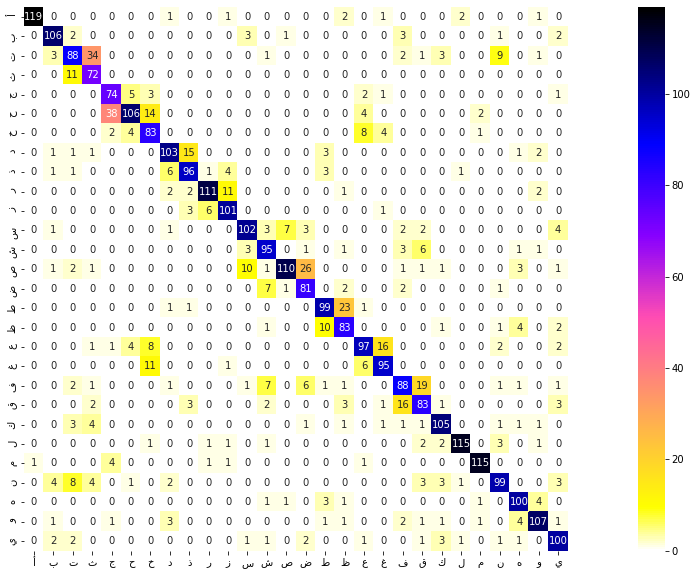

In [10]:
y_pred = model.predict(x_test)
y_classes = [np.argmax(element) for element in y_pred]
y_classes12 = [np.argmax(element) for element in y_test]
a=confusion_matrix(y_classes, y_classes12)
df_cm = pd.DataFrame(a, index = [i for i in "أبتثجحخدذرزسشصضطظعغفقكلمنهوي"],
                  columns = [i for i in "أبتثجحخدذرزسشصضطظعغفقكلمنهوي"])
plt.figure(figsize = (25,10))
sn.heatmap(df_cm, annot=True,cmap="gnuplot2_r",fmt='g', square=True)

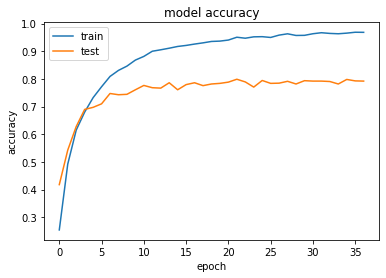

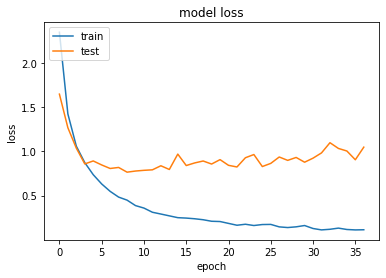

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# CNN model

In [16]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', 
                        input_shape=(32, 32,1)))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(28, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])
monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=5, 
        verbose=1, mode='auto', restore_best_weights=True)


history=model.fit(x_train, y_train,validation_data=(x_val,y_val),callbacks=[monitor], epochs=100,verbose=1, batch_size = 32)
accuracy=model.evaluate(x_test,y_test)
accuracy

Train on 12038 samples, validate on 1338 samples
Epoch 1/100
12038/12038 [==============================] - 3s 243us/step - loss: 2.1156 - accuracy: 0.3622 - val_loss: 0.7860 - val_accuracy: 0.7788
Epoch 2/100
12038/12038 [==============================] - 3s 211us/step - loss: 0.9049 - accuracy: 0.7037 - val_loss: 0.4235 - val_accuracy: 0.8580
Epoch 3/100
12038/12038 [==============================] - 3s 210us/step - loss: 0.6338 - accuracy: 0.7887 - val_loss: 0.2875 - val_accuracy: 0.9155
Epoch 4/100
12038/12038 [==============================] - 3s 211us/step - loss: 0.5005 - accuracy: 0.8286 - val_loss: 0.2312 - val_accuracy: 0.9305
Epoch 5/100
12038/12038 [==============================] - 3s 212us/step - loss: 0.4177 - accuracy: 0.8588 - val_loss: 0.1988 - val_accuracy: 0.9387
Epoch 6/100
12038/12038 [==============================] - 3s 215us/step - loss: 0.3540 - accuracy: 0.8823 - val_loss: 0.1717 - val_accuracy: 0.9395
Epoch 7/100
12038/12038 [==============================] 

[0.09794679754001794, 0.9743589758872986]

# Saving the model & model's history

In [106]:
accuracy=round(accuracy[1],5)*100

save_model=str(accuracy)+"KaggleDS_"+str(seed)

pickle_out = open(save_model,"wb")
pickle.dump(history, pickle_out) 
pickle_out.close()

model.save(save_model+".h5")

# Loading the model & model's history

In [107]:
pickle_in= open(save_model,"rb")
history=pickle.load(pickle_in)

model=load_model(save_model+".h5")

# Plotting train vs test accuracy & loss

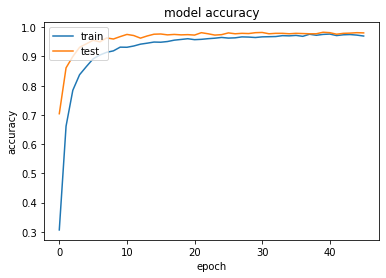

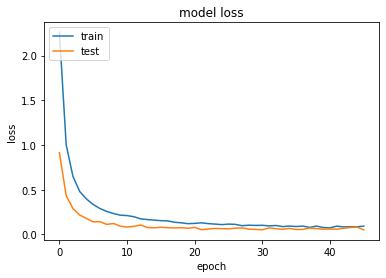

In [108]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'vaildation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'vaildation'], loc='upper left')
plt.show()

# Showing some misclassified images

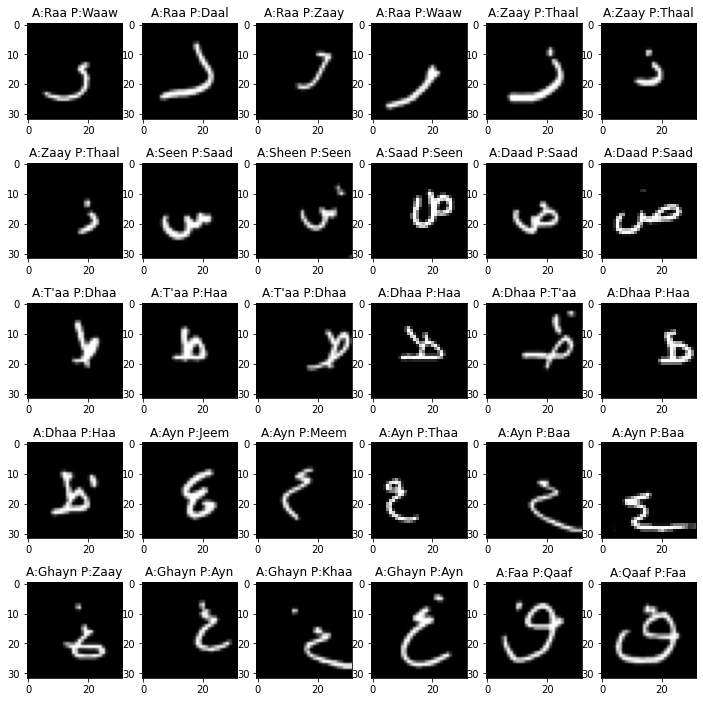

In [121]:
y_pred = model.predict(x_test)
y_classes = [np.argmax(element) for element in y_pred]
y_classes12 = [np.argmax(element) for element in y_test]
y_acutal=[]
y_miss=[]
ind=[]
img=[]
for i in range(3354):
     if y_classes[i] != y_classes12[i]:
        y_acutal.append(y_classes12[i])
        y_miss.append(y_classes[i])
        img.append(x_test[i])

plt.figure(figsize=(12 ,15))
for i in range(30):
    plt.subplot(6,6,i+1)
    plt.imshow(img[i],"gray")
    plt.title("A:"+arabic_characters[y_acutal[i]]+" P:"+arabic_characters[y_miss[i]])
plt.show()

# Confusion matrix

<AxesSubplot:>

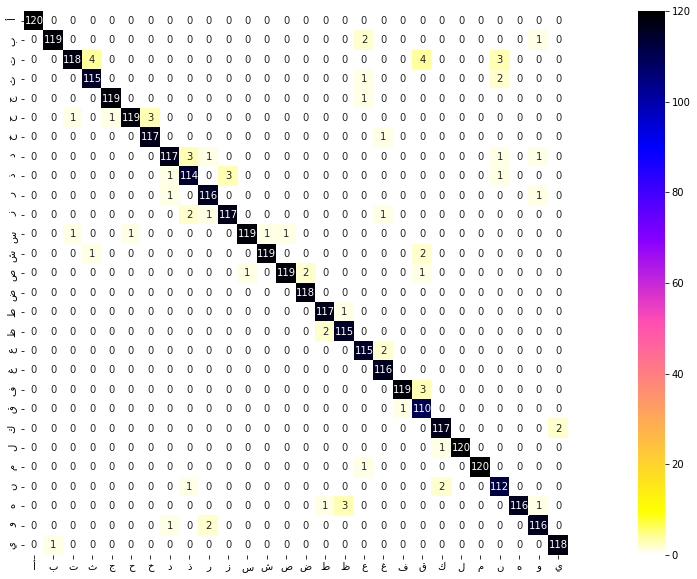

In [122]:
a=confusion_matrix(y_classes, y_classes12)
df_cm = pd.DataFrame(a, index = [i for i in "أبتثجحخدذرزسشصضطظعغفقكلمنهوي"],
                  columns = [i for i in "أبتثجحخدذرزسشصضطظعغفقكلمنهوي"])
plt.figure(figsize = (25,10))
sn.heatmap(df_cm, annot=True,cmap="gnuplot2_r",fmt='g', square=True)

# Classification report

In [112]:
c=classification_report(y_classes, y_classes12, output_dict=True)
df=pd.DataFrame(c).transpose()
df.index=["أ" ,"ب" ,"ت" ,"ث" ,"ج" ,"ح" ,"خ" ,"د" ,"ذ" ,"ر" ,"ز","س","ش","ص","ض","ط","ظ","ع","غ","ف","ق","ك","ل","م","ن","ه","و","ي",'accuracy', 'macro avg', 'weighted avg']
df

,precision,recall,f1-score,support
أ,1.000000,1.000000,1.000000,120.000000
ب,1.000000,0.975610,0.987654,123.000000
ت,0.983333,0.967213,0.975207,122.000000
ث,0.991667,0.991667,0.991667,120.000000
ج,1.000000,1.000000,1.000000,120.000000
ح,1.000000,1.000000,1.000000,120.000000
خ,1.000000,1.000000,1.000000,120.000000
د,0.950000,0.974359,0.962025,117.000000
ذ,0.925000,0.982301,0.952790,113.000000
ر,1.000000,0.937500,0.967742,128.000000
